In [1]:
from kalmanODE_jax import *
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from scipy.integrate import odeint
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_blas
import sys
sys.path.append("..")
%load_ext Cython

In [3]:
from math import sin
import jax.numpy as jnp
def fun(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = jnp.zeros(1)
    x_out[0] = sin(2*t) - x[0]
    return x_out

def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [4]:
# LHS vector of ODE
w_mat = np.array([[0.0, 0.0, 1.0]], order='F')

# These parameters define the order of the ODE and the CAR(p) process
n_deriv = [2]
n_deriv_prior = [4]

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 100
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = [.5]

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(x0, n_deriv, n_deriv_prior)
kinit = ibm_init(dt, n_deriv_prior, sigma)
#kinit = indep_init(ode_init, n_deriv_prior)

In [5]:
z_state = rand_mat(2*n_eval, sum(n_deriv_prior))
kalmanode = KalmanODE_blas(W = W, tmin = tmin, tmax = tmax, n_eval = n_eval, ode_fun = fun, **kinit)
kalmanode.z_state = z_state
ksim_cy = kalmanode.solve_sim(x0_state, method="chkrebtii")

In [6]:
ksim_jax = \
    solve_sim(x0_state, tmin, tmax, n_eval, kinit['wgt_state'], kinit['mu_state'], 
              kinit['var_state'], W, z_state, theta=None)

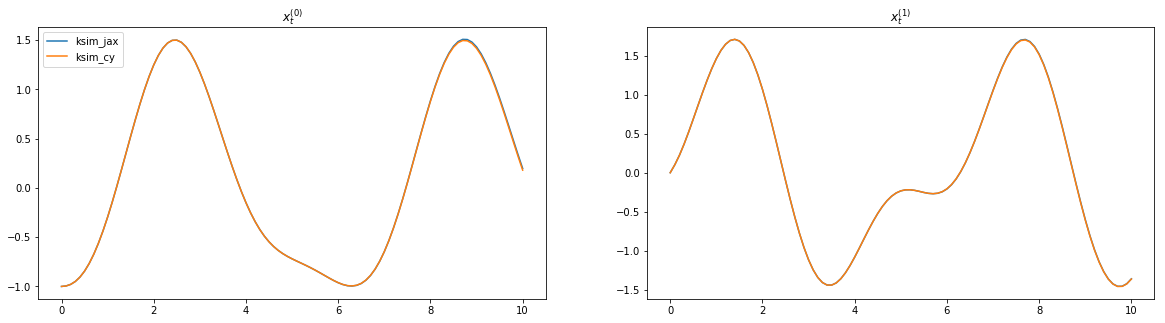

In [7]:
# ode function in odeint format
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = odeint(f, [-1, 0], tseq)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, ksim_jax[:,0], label='ksim_jax')
axs[0].plot(tseq, ksim_cy[:,0], label='ksim_cy')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, ksim_jax[:,1], label='ksim_jax')
axs[1].plot(tseq, ksim_cy[:,1], label='ksim_cy')
axs[1].set_title("$x^{(1)}_t$")
plt.show()